# Imports

In [319]:
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input,Dense,MaxPool2D,Flatten, UpSampling2D,Reshape,BatchNormalization
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

print(tf.__version__)

2.2.0-rc1


# Load dataset

In [320]:
(x_train,y_train),(x_test,y_test)=mnist=tf.keras.datasets.mnist.load_data()
print('Shape of training images:',x_train.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of test images:',x_test.shape)
print('Shape of test labels:',y_test.shape)

Shape of training images: (60000, 28, 28)
Shape of training labels: (60000,)
Shape of test images: (10000, 28, 28)
Shape of test labels: (10000,)


# Inspect dataset

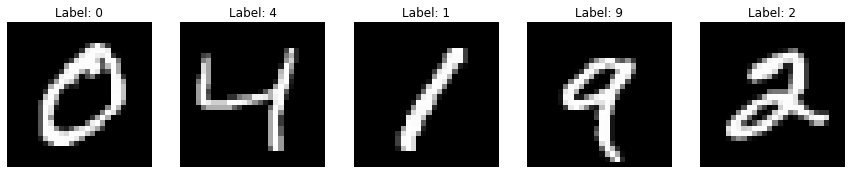

In [321]:
fig=plt.figure(figsize=(15,3))

n=1
for i in range(5):
    plt.subplot(1,5,n)
    plt.imshow(x_train[n],cmap='gray') 
    plt.title('Label: '+str(y_train[n]))
    plt.axis('off')
    n+=1
plt.show()


 # Prepare dataset

Scale input images to range from 0..1 and convert the class labels to 

*   Convert image array to NHWC shape
*   Scale input images to range from 0..1
*   Convert the class labels to one-hot-encoded format


In [0]:
x_train , x_test = x_train.reshape(-1,28,28,1)/255.  ,   x_test.reshape(-1,28,28,1)/255.
y_train , y_test = np.eye(10)[y_train]   ,   np.eye(10)[y_test]  # not necessary in this gan model

# GAN

## Discriminator model


In [325]:

def build_discriminator():
  input=Input(shape=(28,28,1))

  #downsampling
  x=Conv2D(8,kernel_size=(3,3),padding='same',activation='relu')(input) # output => 28x28x8
  x=BatchNormalization()(x)

  x=MaxPool2D(pool_size=(2,2))(x)                                       # output => 14x14x8
  x=Conv2D(16,kernel_size=(3,3),padding='same',activation='relu')(x)    # output => 14x14x16
  x=BatchNormalization()(x)

  x=MaxPool2D(pool_size=(2,2))(x)                                       # output => 7x7x16
  x=Conv2D(32,kernel_size=(3,3),padding='same',activation='relu')(x)    # output => 7x7x32
  x=BatchNormalization()(x)

  x=Flatten()(x)                                                        # output => 1568
  x=Dense(512,activation='relu')(x)                                     # output => 512
  x=BatchNormalization()(x)

  output=Dense(2,activation='softmax')(x)                               # output => 2

  discriminator=tf.keras.models.Model(inputs=input,outputs=output)
  return discriminator

discriminator=build_discriminator()

print(discriminator.summary())


Model: "model_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 28, 28, 8)         80        
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 8)         32        
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_152 (Conv2D)          (None, 14, 14, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 7, 7, 16)          0  


## Generator model

In [326]:
def build_generator():

  #upsampling
  input=Input(shape=(100,))                                                                 #100

  x=Dense(512)(input)                                                                       #512
  x=BatchNormalization()(x)

x=Dense(1568)(x)                                                                            #1578
  x=BatchNormalization()(x)

  x=Reshape(target_shape=(7,7,32))(x)                                                       #7x7x32
  x=Conv2D(16,kernel_size=(3,3),padding='same',activation='relu')(x)                        #7x7x16
  x=BatchNormalization()(x)

  x=Conv2DTranspose(16,kernel_size=(3,3),padding='same',activation='relu',strides=(2,2))(x) #14x14x16
  x=BatchNormalization()(x)

  x=Conv2D(8,kernel_size=(3,3),padding='same',activation='relu')(x)                         #14x14x8
  x=BatchNormalization()(x)

  x=Conv2DTranspose(8,kernel_size=(3,3),padding='same',activation='relu',strides=(2,2))(x)  #28x28x8
  x=BatchNormalization()(x)

  output=Conv2D(1,kernel_size=(3,3),padding='same',activation='sigmoid')(x)                 #28x28x1

  generator=tf.keras.models.Model(inputs=input,outputs=output)
  return generator

generator=build_generator()

print(generator.summary())

Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense_105 (Dense)            (None, 512)               51712     
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_106 (Dense)            (None, 1568)              804384    
_________________________________________________________________
batch_normalization_5 (Batch (None, 1568)              6272      
_________________________________________________________________
reshape_30 (Reshape)         (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 7, 7, 16)          462

## Batch Generator

In [0]:
class BatchGenerator(tf.keras.utils.Sequence):
  def __init__(self,images,batchsize):
    self.images=images
    self.batchsize=batchsize

  def __len__(self):
   return int(np.floor(len(self.images) / self.batchsize))

  def __getitem__(self, index):
    return self.images[index*self.batchsize:(index+1)*self.batchsize]

  def __on_epoch_end(self):
    p=np.random.permutation(len(self.images))
    self.images=self.images[p]
    
batch_generator=BatchGenerator(images=x_train,batchsize=32)


## Define Loss Functions

The generators aim is to trick the discriminator to make false predictions. In order to define a loss function that fits this aim, the targets for all the generated images are set to 1 in the first neuron of the descriminator.
So the generator is penalized if the descriminator makes the prediction "real" for the generated images.

The descriminator has the task to decide if an image is fake or real. The real images get the target 1 in the first classification neuron. The fake images get the target of 1 in the second classification neuron.



In [0]:
def gen_loss(fake_output):

  #fake_output shape: bs x 2
  # categorical crossentropy: index 0 => real, index 1 =>fake
  loss=K.log(fake_output[:,0])*K.ones(fake_output[:,0].shape) #+np.log(fake_output[:,1])*np.zeros(fake_output[:,1].shape)
  loss=-K.mean(loss) #average over batch
  return loss


def desc_loss(fake_output,real_output):
  fake_loss=K.log(fake_output[:,1])*K.ones(fake_output[:,1].shape)
  real_loss=K.log(real_output[:,0])*K.ones(real_output[:,0].shape)
  loss=fake_loss+real_loss
  loss=-K.mean(loss) #average over batch
  return loss

## Training Loop

Start Training with  15 Epochs and 1875 Batches per Epoch.
Epoch:  0


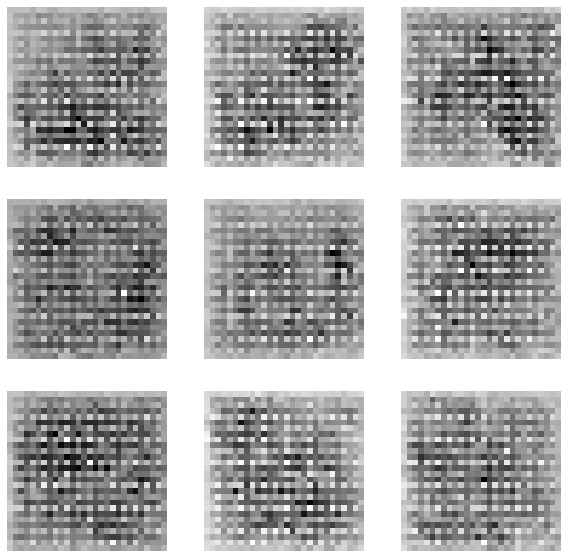

Generator Loss:      tf.Tensor(4.311152, shape=(), dtype=float32)
Discriminator Loss:  tf.Tensor(0.15053186, shape=(), dtype=float32)
Epoch:  1


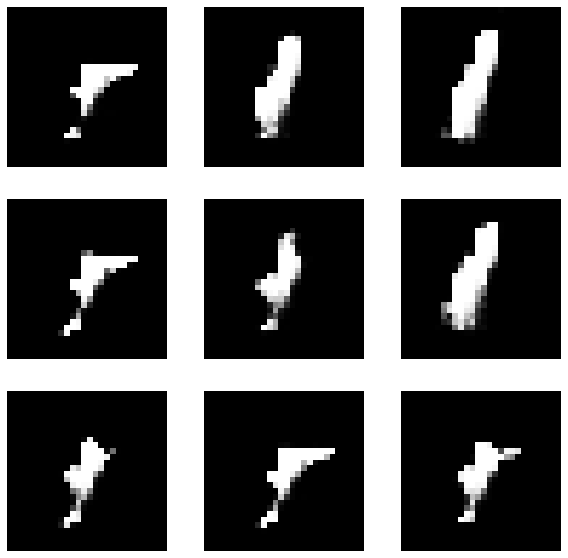

Generator Loss:      tf.Tensor(3.1698117, shape=(), dtype=float32)
Discriminator Loss:  tf.Tensor(0.5197523, shape=(), dtype=float32)
Epoch:  2


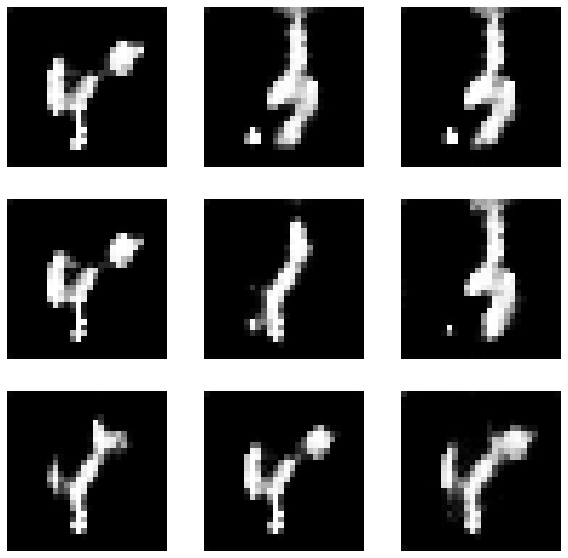

Generator Loss:      tf.Tensor(1.8805285, shape=(), dtype=float32)
Discriminator Loss:  tf.Tensor(0.30648416, shape=(), dtype=float32)
Epoch:  3


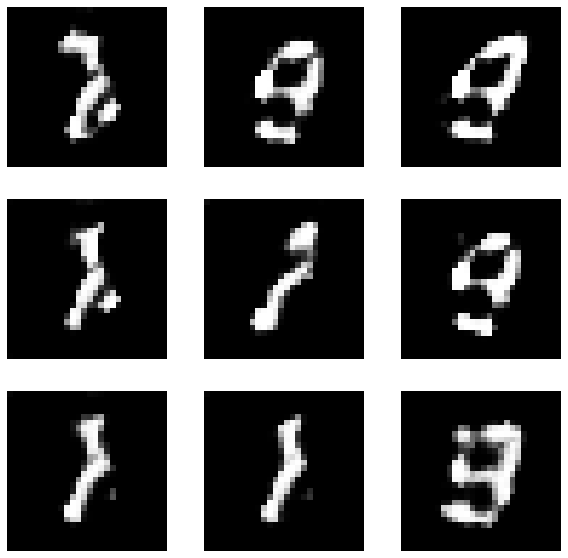

Generator Loss:      tf.Tensor(4.4739084, shape=(), dtype=float32)
Discriminator Loss:  tf.Tensor(0.18029013, shape=(), dtype=float32)
Epoch:  4


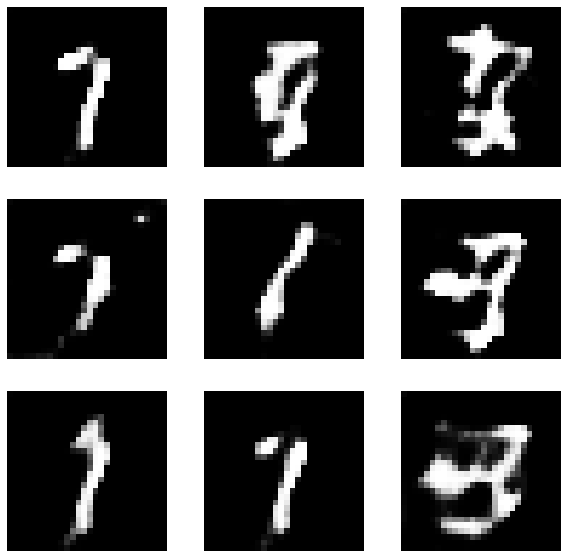

Generator Loss:      tf.Tensor(2.6874664, shape=(), dtype=float32)
Discriminator Loss:  tf.Tensor(0.46386936, shape=(), dtype=float32)
Epoch:  5


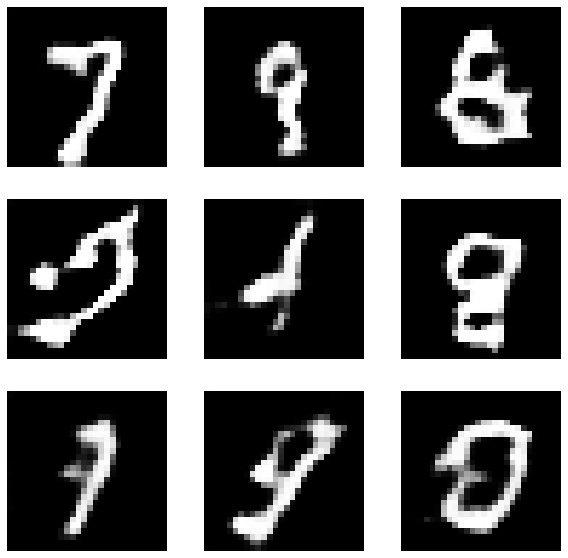

Generator Loss:      tf.Tensor(2.0344243, shape=(), dtype=float32)
Discriminator Loss:  tf.Tensor(0.6802331, shape=(), dtype=float32)
Epoch:  6


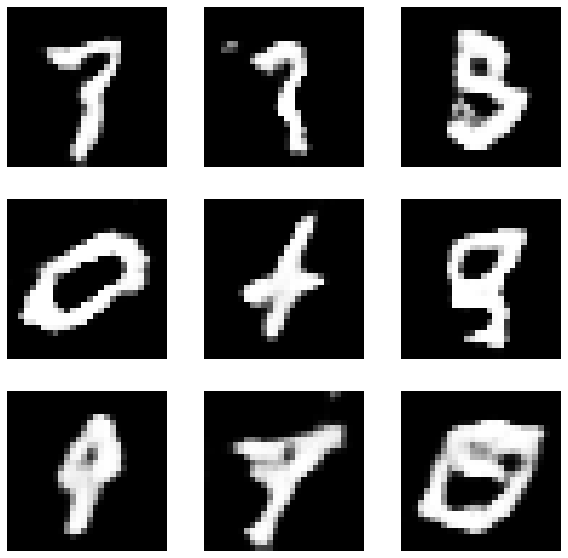

Generator Loss:      tf.Tensor(1.6200287, shape=(), dtype=float32)
Discriminator Loss:  tf.Tensor(0.6370557, shape=(), dtype=float32)
Epoch:  7


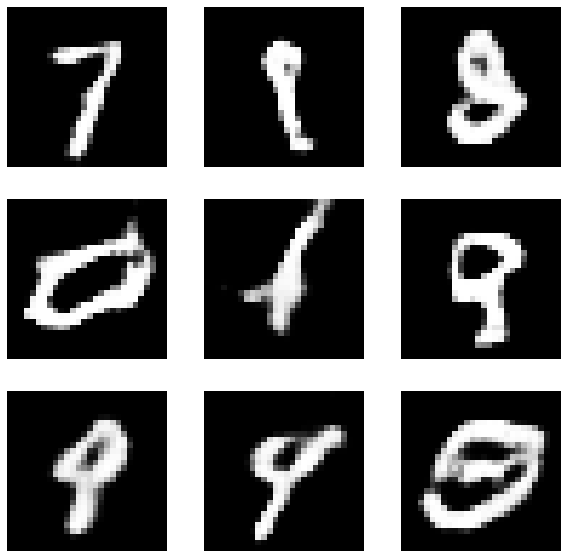

Generator Loss:      tf.Tensor(1.6245322, shape=(), dtype=float32)
Discriminator Loss:  tf.Tensor(0.6072162, shape=(), dtype=float32)
Epoch:  8


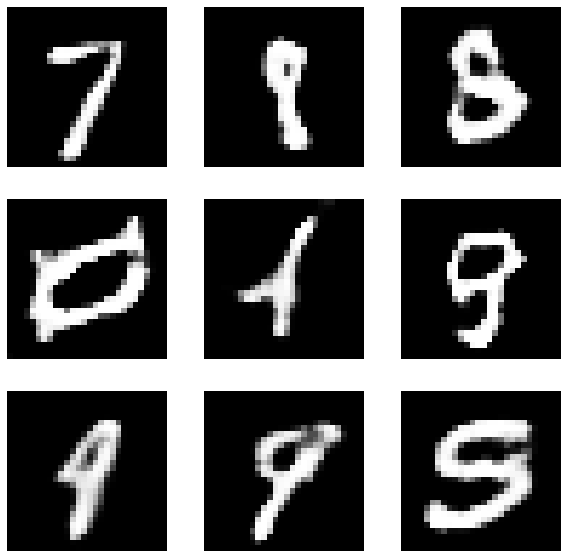

Generator Loss:      tf.Tensor(1.5708444, shape=(), dtype=float32)
Discriminator Loss:  tf.Tensor(0.5347483, shape=(), dtype=float32)
Epoch:  9


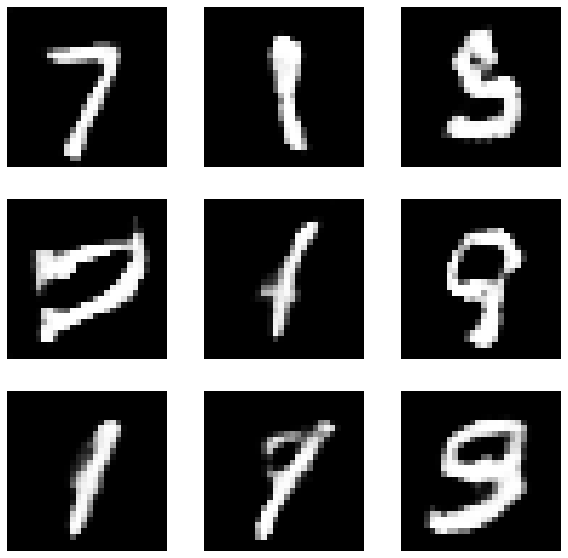

Generator Loss:      tf.Tensor(1.687658, shape=(), dtype=float32)
Discriminator Loss:  tf.Tensor(0.46641234, shape=(), dtype=float32)
Epoch:  10


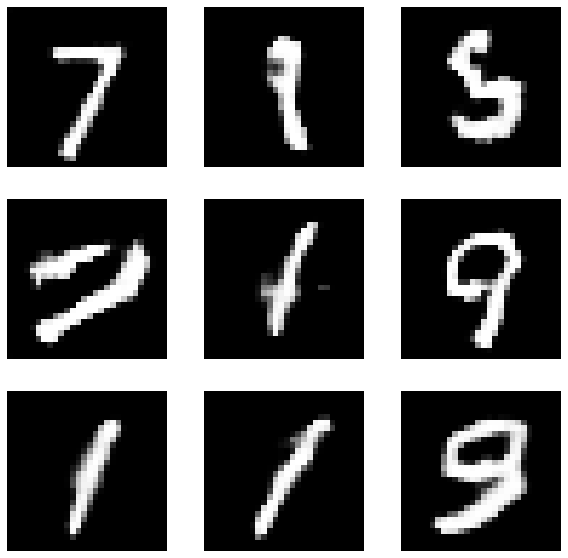

Generator Loss:      tf.Tensor(1.1950545, shape=(), dtype=float32)
Discriminator Loss:  tf.Tensor(0.7081494, shape=(), dtype=float32)
Epoch:  11


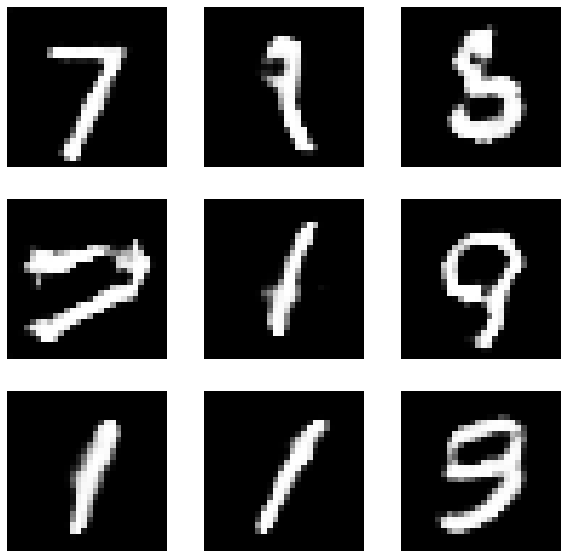

Generator Loss:      tf.Tensor(1.3038101, shape=(), dtype=float32)
Discriminator Loss:  tf.Tensor(0.6164955, shape=(), dtype=float32)
Epoch:  12


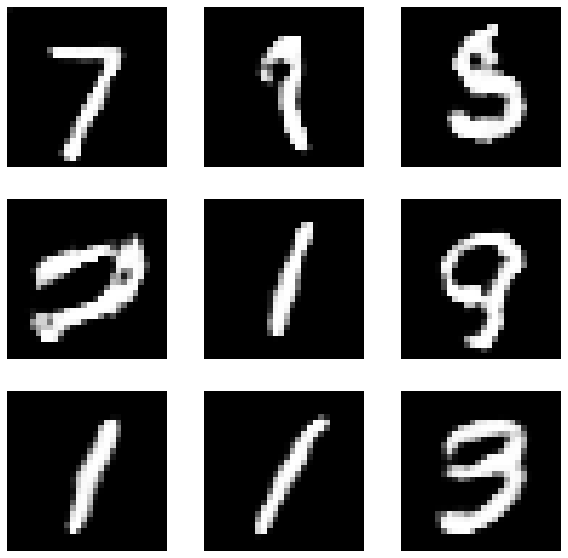

Generator Loss:      tf.Tensor(1.6301632, shape=(), dtype=float32)
Discriminator Loss:  tf.Tensor(0.5831089, shape=(), dtype=float32)
Epoch:  13


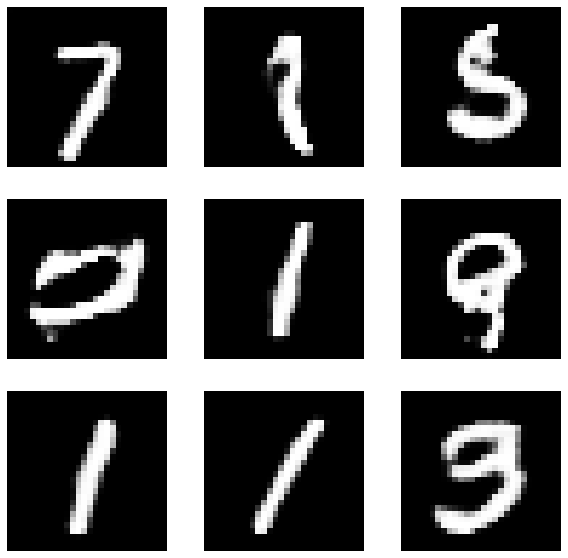

Generator Loss:      tf.Tensor(1.876858, shape=(), dtype=float32)
Discriminator Loss:  tf.Tensor(0.43092042, shape=(), dtype=float32)
Epoch:  14


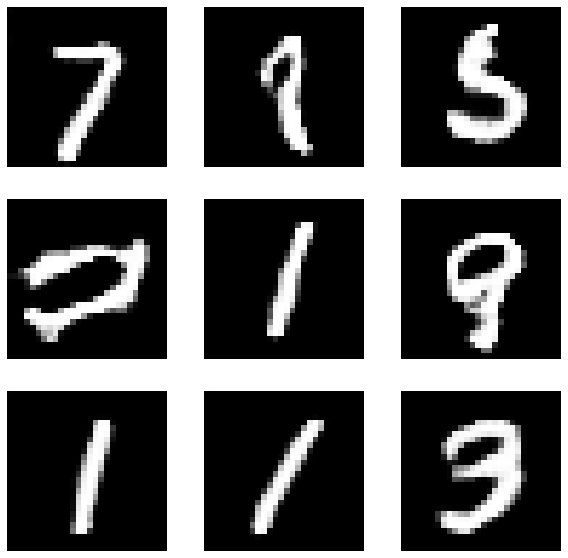

Generator Loss:      tf.Tensor(2.023739, shape=(), dtype=float32)
Discriminator Loss:  tf.Tensor(0.36921933, shape=(), dtype=float32)


In [329]:

def train(epochs):

  generator_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4,b)
  discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
  seed=np.random.normal(size=(9,100))
  generator_losses=[]
  discriminator_losses=[]


  print('Start Training with ',epochs,'Epochs and',len(batch_generator),'Batches per Epoch.')
  for epoch in range(epochs):
    print('Epoch: ',epoch)

   
    plt.figure(figsize=(10,10))
    for i in range(9):
      example_image=generator(seed)[i,:,:,0]
      plt.subplot(3,3,i+1)
      plt.axis('off')
      plt.imshow(example_image,cmap='gray')
    plt.show()

    
    for i in range(len(batch_generator)):
      # print('Batch:' ,i)

      noise=np.random.normal(size=(32,100))
      with tf.GradientTape() as disc_tape,tf.GradientTape() as gen_tape:
        generated_images=generator(noise)
        

        fake_output=discriminator(generated_images)
        real_output=discriminator(batch_generator[i])

        generator_loss=gen_loss(fake_output)
        discriminator_loss=desc_loss(fake_output,real_output)



        generator_gradients = gen_tape.gradient(generator_loss, generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))


    generator_losses.append(generator_loss.numpy())
    discriminator_losses.append(discriminator_loss.numpy())

    print('Generator Loss:     ', generator_loss.numpy())
    print('Discriminator Loss: ', discriminator_loss.numpy())


  return generator_losses,discriminator_losses
        

  

    

generator_losses,discriminator_losses= train(epochs=15)


## Example images

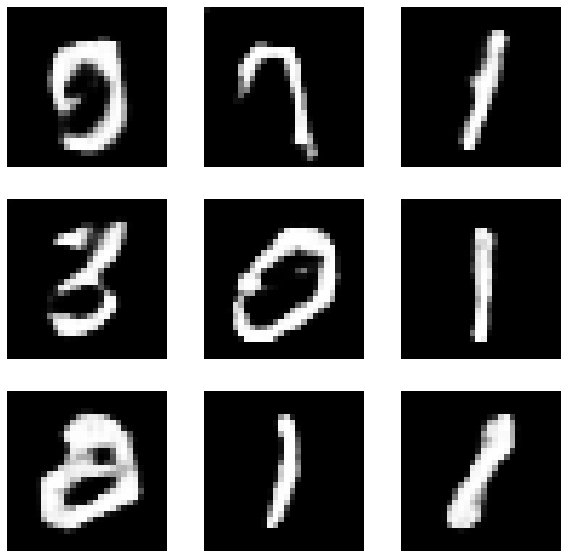

In [338]:
seed=np.random.normal(size=(9,100))

plt.figure(figsize=(10,10))

for i in range(9):

  example_image=generator(seed)[i,:,:,0]
  plt.subplot(3,3,i+1)
  plt.axis('off')
  plt.imshow(example_image,cmap='gray')

plt.show()

## Learning Curve

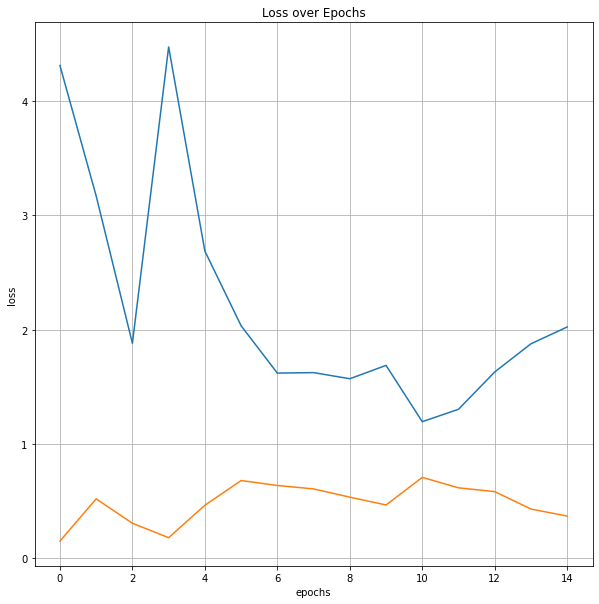

In [331]:
plt.figure(figsize=(10,10))
plt.plot(generator_losses)
plt.plot(discriminator_losses)
plt.title('Loss over Epochs')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()